In [46]:
# %%
# Imports
import os
import numpy as np
import seaborn as sns
import polars as pl
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import matplotlib.pyplot as plt

In [47]:
# %%
# Load data
def get_file_path(file_name):
    path = f"{file_name}"
    if not os.path.exists(path):
        path = f"/your_code/{path}"
    return path


def set_random_seed(seed):
    # Sets random seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

print("This is a node embedding matrix of each node in the graph - X features for prediction")
X_df = pl.read_csv(get_file_path("Data/precomputed_node_embeddings_128.gz")) # Node embeddings
print(X_df)

user_df = pl.read_csv(get_file_path("Data/precomputed_scores.gz")) # Calculated broker/source spreader scores

print("This is a dataframe of the calculated broker/source spreader scores - Y target for prediction")
print(user_df)

This is a node embedding matrix of each node in the graph - X features for prediction
shape: (456_623, 128)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆ … ┆ 124       ┆ 125       ┆ 126       ┆ 127      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.000012 ┆ 0.001237  ┆ -0.000929 ┆ -0.003082 ┆ … ┆ -0.00221  ┆ 0.001573  ┆ 0.003246  ┆ -0.00087 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 9        │
│ -0.001472 ┆ -0.007436 ┆ -0.007803 ┆ -0.007529 ┆ … ┆ 0.000465  ┆ 0.0009    ┆ -0.007064 ┆ -0.00653 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆       

In [48]:
# %%
# Train-test split
Y = pl.Series(user_df["broker_score"])
X_train, X_test, Y_train, Y_test = train_test_split(
    X_df, Y, train_size=0.9, shuffle=True, random_state=0
)
Y_train: pl.DataFrame = Y_train.to_frame()
Y_test: pl.DataFrame = Y_test.to_frame()

bins = [-float("inf"), 0, 25, 100, 500, 10000, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

Y_train = Y_train.with_columns(pl.Series(name="index", values=range(len(Y_train))))
high_value_indices = Y_train.filter(pl.col("broker_score") >= 10000)["index"]
medium_value_indices = Y_train.filter((pl.col("broker_score") >= 500) & (pl.col("broker_score") < 10000))["index"]
low_value_indices = Y_train.filter(pl.col("broker_score") < 10000)["index"]

In [49]:
# Perform PCA to reduce dimensions to 2
n = -1
if n == -1:
    X_df_trimmed = X_df
    n = len(X_df)
    user_df_trimmed = user_df
else:
    X_df_trimmed = X_df.head(n)
    user_df_trimmed = user_df.head(n)
pca = PCA(n_components=2)
pca_50 = PCA(n_components=10)
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1, max_iter=250)
X_df_pca = pca.fit_transform(X_df_trimmed.to_numpy())
X_df_pca = pl.DataFrame(X_df_pca, schema=["PC1", "PC2"])

if os.path.exists("Data/precomputed_node_embeddings_tsne.gz"):
    X_df_tsne = pl.read_csv("Data/precomputed_node_embeddings_tsne.gz").head(n)
else:
    X_df_tsne = tsne.fit_transform(pca_50.fit_transform(X_df_trimmed.to_numpy()))
    X_df_tsne = pl.DataFrame(X_df_tsne, schema=['TSNE1', 'TSNE2'])
    X_df_tsne.write_csv('Data/precomputed_node_embeddings_tsne.gz')

print(X_df_tsne)

shape: (456_623, 2)
┌───────────┬───────────┐
│ TSNE1     ┆ TSNE2     │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ 3.1501496 ┆ 0.42827   │
│ 3.2321892 ┆ 0.5616664 │
│ -3.13864  ┆ -1.345006 │
│ -2.32143  ┆ -1.695703 │
│ -2.057602 ┆ -1.821031 │
│ …         ┆ …         │
│ 2.9723203 ┆ 0.518539  │
│ -1.354182 ┆ 1.8543905 │
│ -4.227657 ┆ -0.414461 │
│ -1.54352  ┆ -0.693598 │
│ -3.104402 ┆ -1.812377 │
└───────────┴───────────┘


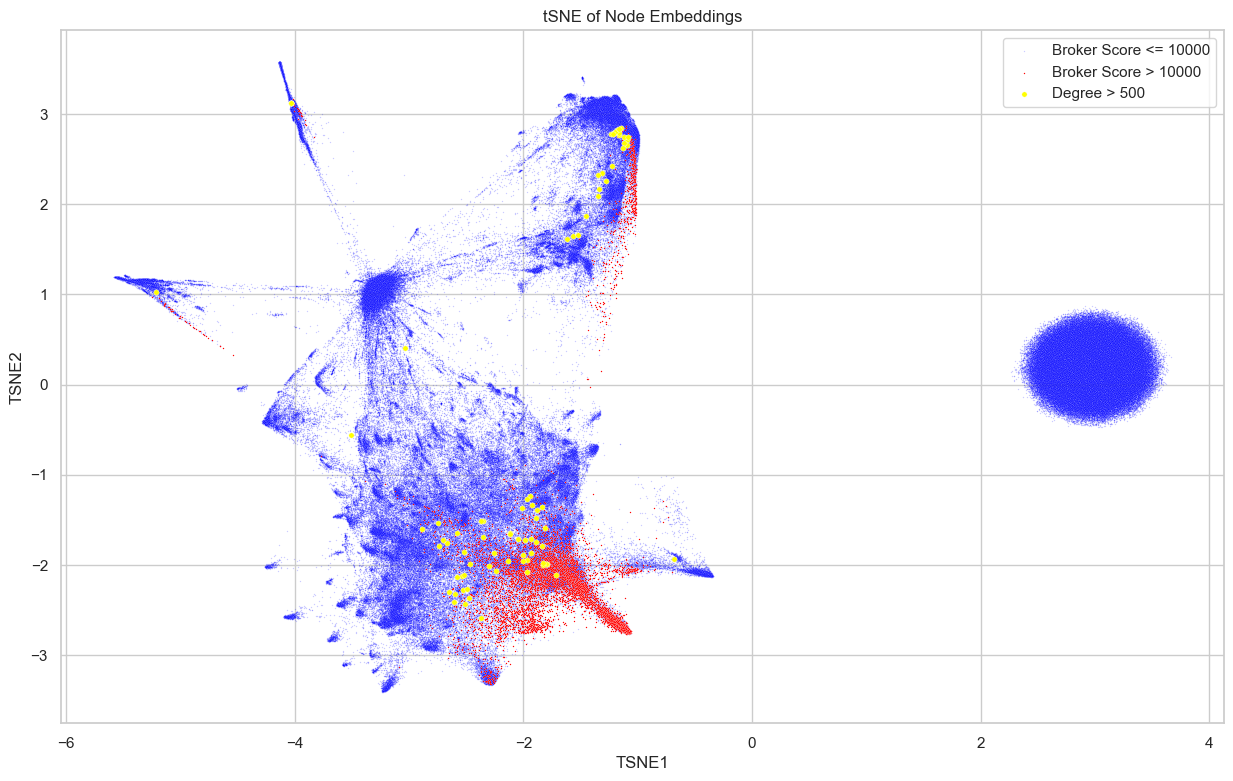

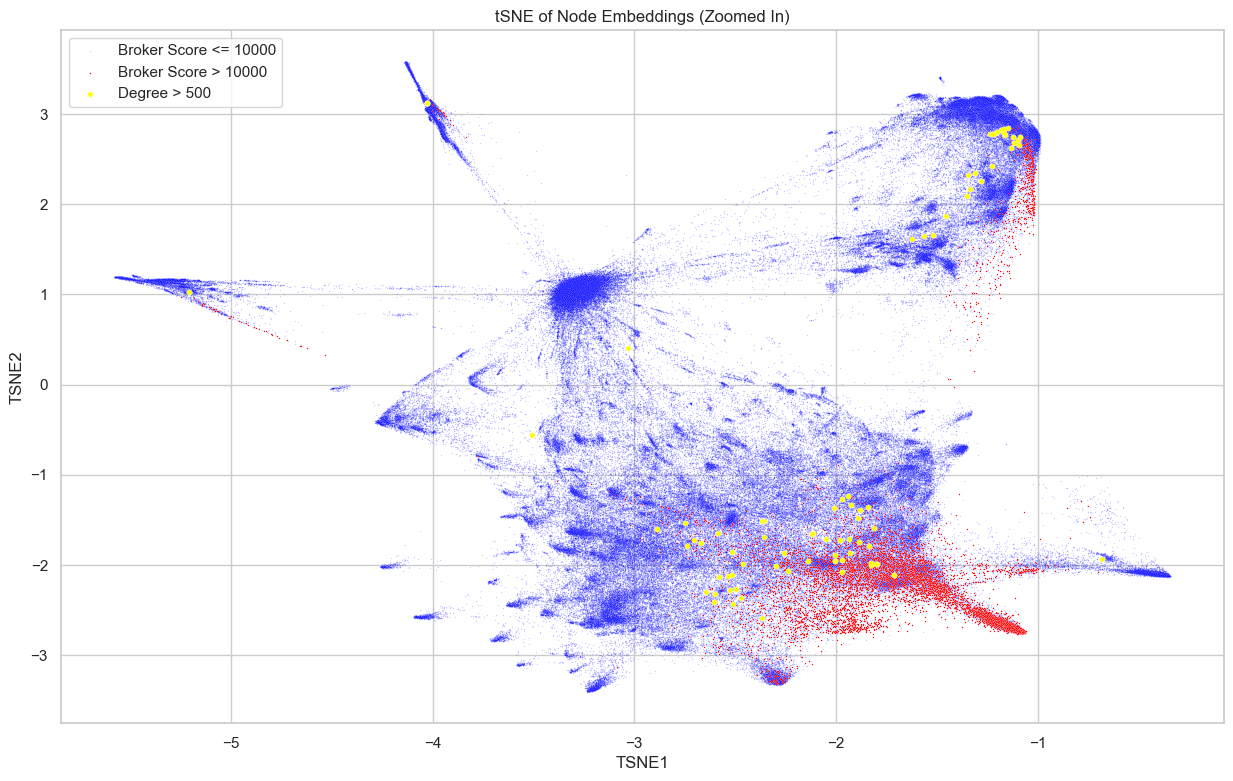

In [50]:
# Plot using seaborn
plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    data=X_df_tsne.filter(user_df_trimmed["broker_score"] <= 10000),
    x='TSNE1',
    y='TSNE2',
    color='blue',
    label='Broker Score <= 10000',
    s=1,
    alpha=0.2
)
sns.scatterplot(
    data=X_df_tsne.filter(user_df_trimmed["broker_score"] > 10000),
    x='TSNE1',
    y='TSNE2',
    color='red',
    label='Broker Score > 10000',
    s=1,
    alpha=1.0
)
sns.scatterplot(
    data=X_df_tsne.filter(user_df_trimmed["source_spreader_score"] > 500),
    x='TSNE1',
    y='TSNE2',
    color='yellow',
    label='Degree > 500',
    s=15,
    alpha=1.0
)
plt.title('tSNE of Node Embeddings')
plt.legend()
plt.show()

plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    data=X_df_tsne.filter((user_df_trimmed["broker_score"] <= 10000) & (X_df_tsne["TSNE1"] < 0)),
    x='TSNE1',
    y='TSNE2',
    color='blue',
    label='Broker Score <= 10000',
    s=1,
    alpha=0.2
)
sns.scatterplot(
    data=X_df_tsne.filter((user_df_trimmed["broker_score"] > 10000) & (X_df_tsne["TSNE1"] < 0)),
    x='TSNE1',
    y='TSNE2',
    color='red',
    label='Broker Score > 10000',
    s=1,
    alpha=1.0
)
sns.scatterplot(
    data=X_df_tsne.filter((user_df_trimmed["source_spreader_score"] > 500) & (X_df_tsne["TSNE1"] < 0)),
    x='TSNE1',
    y='TSNE2',
    color='yellow',
    label='Degree > 500',
    s=15,
    alpha=1.0
)
plt.title('tSNE of Node Embeddings (Zoomed In)')
plt.legend()
plt.show()

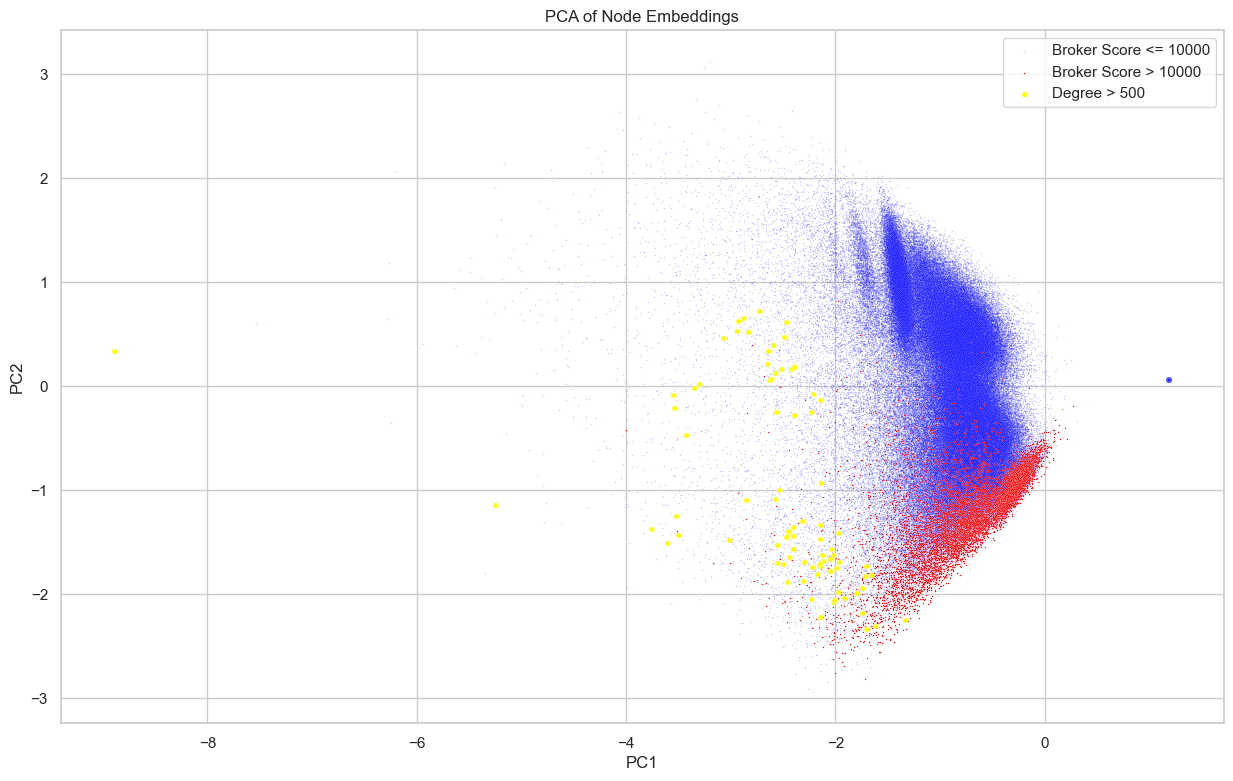

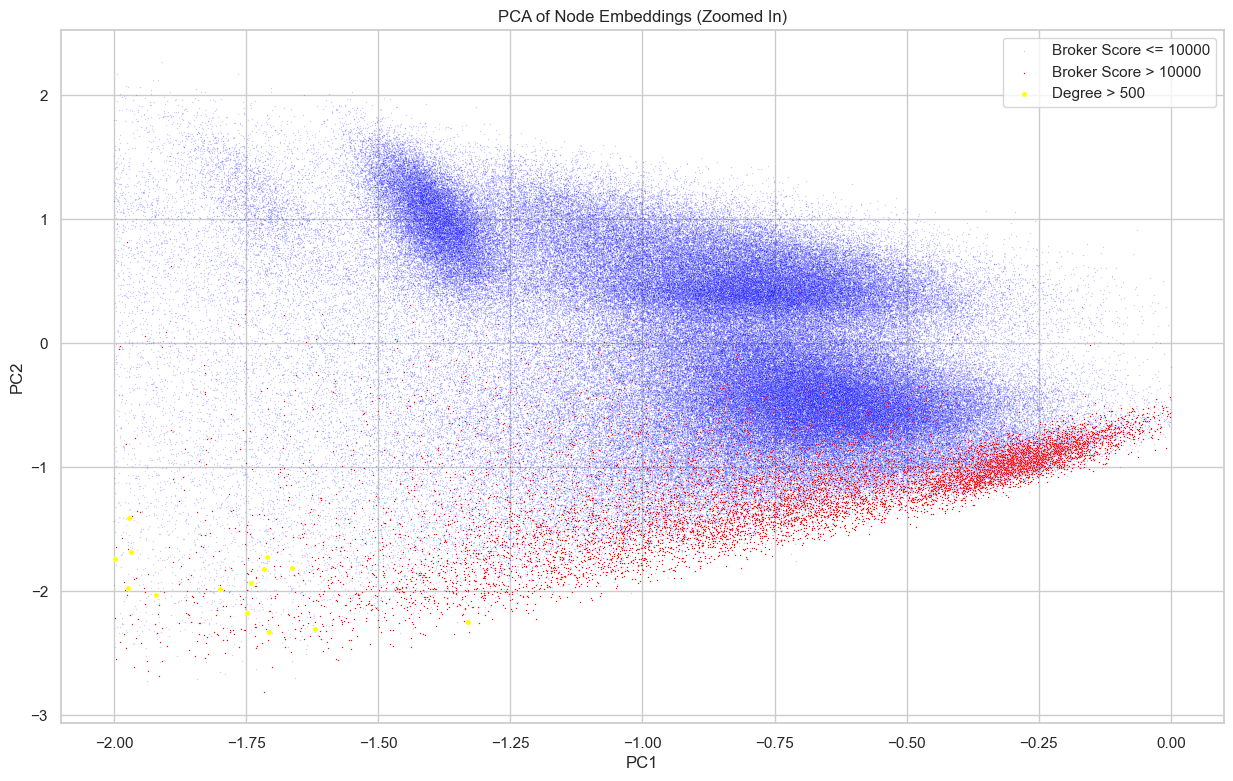

In [51]:
# Plot using seaborn
plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    data=X_df_pca.filter(user_df_trimmed["broker_score"] <= 10000),
    x='PC1',
    y='PC2',
    color='blue',
    label='Broker Score <= 10000',
    s=1,
    alpha=0.2
)
sns.scatterplot(
    data=X_df_pca.filter(user_df_trimmed["broker_score"] > 10000),
    x='PC1',
    y='PC2',
    color='red',
    label='Broker Score > 10000',
    s=1,
    alpha=1.0
)
sns.scatterplot(
    data=X_df_pca.filter(user_df_trimmed["source_spreader_score"] > 500),
    x='PC1',
    y='PC2',
    color='yellow',
    label='Degree > 500',
    s=15,
    alpha=1.0
)
plt.title('PCA of Node Embeddings')
plt.legend()
plt.show()

plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(
    data=X_df_pca.filter((user_df_trimmed["broker_score"] <= 10000) & (X_df_pca["PC1"] > -2) & (X_df_pca["PC1"] < 0)),
    x='PC1',
    y='PC2',
    color='blue',
    label='Broker Score <= 10000',
    s=1,
    alpha=0.2
)
sns.scatterplot(
    data=X_df_pca.filter((user_df_trimmed["broker_score"] > 10000) & (X_df_pca["PC1"] > -2) & (X_df_pca["PC1"] < 0)),
    x='PC1',
    y='PC2',
    color='red',
    label='Broker Score > 10000',
    s=1,
    alpha=1.0
)
sns.scatterplot(
    data=X_df_pca.filter((user_df_trimmed["source_spreader_score"] > 500) & (X_df_pca["PC1"] > -2) & (X_df_pca["PC1"] < 0)),
    x='PC1',
    y='PC2',
    color='yellow',
    label='Degree > 500',
    s=15,
    alpha=1.0
)
plt.title('PCA of Node Embeddings (Zoomed In)')
plt.legend()
plt.show()